# Genetic Algorithm Assignment
Luke Foley - T00224345

## The Problem         **(~30%)**

#### Description of the problem

My chosen problem for this assignment is the generation of a high resolution image from a single, low resolution input image. The objective is to insert additional pixel details into an image and produce an image with improved fidelity. This project explores the application of a genetic algorithm in tackling this problem.

---

#### Suitablity of Genetic Algorithms

- Genetic algorithms are capable of exploring a large solution space, every possible combination of pixel values can theoretically be evaluated. Each individual represents a potential upscaled image.
- A potentially novel solution for image upscaling

---

#### Complexity of the problem

- Astronomically large search space
- There is no definitive "correct" upscaled version of the input image.
- Determining suitable cost function
- Balance of exporation vs exploitation
- Could be computationally intensive due to search space

## The problem and the cost function   **(~20%)**
Evaluating the "quality" of a generated high resolution image is crucial for the success of the GA. Since there is no "ground truth" high resolution image to compare to, an indirect evaluation method is needed. This project mainly relies on the idea of downscaling consistency. The idea is that if a generated high resolution image is a good upscale, then downscaling it back to the original low resolution dimensions should result in an image very similar to the original low resolution input.

---
### Initial Cost Function
bicubic_downscaled_mse():
- This function downscales the individual back to the original image size using bicubic interpolation with the pillow library. This is a standard downscaling method that takes a 4x4 grid of pixels and estimates a single downscaled pixel.
- For the cost, the mean squared error is calculated between the pixel values of this downscaled image and the original low resolution image. A lower MSE cost indicates that the upscaled image is more consistent with the original, and therefore a better upscaled image.
---
### Challenges
- A challenge this cost function presents is that multiple different high resolution pixel patterns (including noisy ones) could potentially average out to the same pixel values after downscaling with bicubic interpolation. This results in images that achieve a low MSE cost, but contain a large amount of noisy/unnatural looking pixels.
---
### Alternative Cost Functions Explored
multi_downscaled_mse():
- To combat the problem outlined above, an alternative cost function was implemented. This function downscales the individual using three different downscaling techniques - bicubic, bilinear, nearest neighbour.
- The mean squared error is calculated against the original for each of the downscaled results. The final cost produced is the average of these three mean squared error results.
- This cost function imposes more strict constraints than the previous implementation. By requiring the individual to have a low average error across different methods, it guides the algorithm away from noisy solutions that fool the bicubic interpolation by itself.
- This resulted in visually superior results, but convergence was noticebly slower.

In [15]:
import numpy as np
from copy import deepcopy
from PIL import Image
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import random

In [1]:
# MSE of original image array vs downscaled version of upscaled image
def bicubic_downscaled_mse(upscaled_image_array, original_image_array):
    pillow_image = Image.fromarray(upscaled_image_array)
    # Resize it back to the original size using bicubic interpolation
    downscaled = pillow_image.resize((original_image_array.shape[1], original_image_array.shape[0]), Image.BICUBIC)
    # convert back to array so that MSE can be calculated
    downscaled = np.array(downscaled)

    # calculate mean squared error between original image array and the downscaled version of the upscaled image array
    mse = np.square(np.subtract(original_image_array.astype(float), downscaled.astype(float))).mean()
    return mse

In [2]:
def downscale_bicubic(upscaled_image_array, original_image_array):
    pillow_image = Image.fromarray(upscaled_image_array)
    downscaled = pillow_image.resize((original_image_array.shape[1], original_image_array.shape[0]), Image.BICUBIC)
    return np.array(downscaled)

def downscale_bilinear(upscaled_image_array, original_image_array):
    pillow_image = Image.fromarray(upscaled_image_array)
    downscaled = pillow_image.resize((original_image_array.shape[1], original_image_array.shape[0]), Image.BILINEAR)
    return np.array(downscaled)

def downscale_nearest_neighbour(upscaled_image_array, original_image_array):
    pillow_image = Image.fromarray(upscaled_image_array)
    downscaled = pillow_image.resize((original_image_array.shape[1], original_image_array.shape[0]), Image.NEAREST)
    return np.array(downscaled)

def multi_downscaled_mse(upscaled_image_array, original_image_array):
    downscaled_bicubic = downscale_bicubic(upscaled_image_array, original_image_array)
    downscaled_bilinear = downscale_bilinear(upscaled_image_array, original_image_array)
    downscaled_nearest_neighbour = downscale_nearest_neighbour(upscaled_image_array, original_image_array)

    # mean MSE of 3 downscaling methods
    cost = np.mean([
        np.square(np.subtract(original_image_array.astype(float), downscaled_bicubic.astype(float))).mean(),
        np.square(np.subtract(original_image_array.astype(float), downscaled_bilinear.astype(float))).mean(),
        np.square(np.subtract(original_image_array.astype(float), downscaled_nearest_neighbour.astype(float))).mean()
    ])

    return cost

In [3]:
class problem:
    def __init__(self, original_image_array, cost_fn = bicubic_downscaled_mse):
        self.original_image_array = original_image_array
        self.min_value = 0
        self.max_value = 255
        self.acceptable_cost = 100
        self.cost_function = cost_fn


## The Individual **(~30%)**

#### Chromosome
Each individual's chromosome is a numpy array representing the upscaled image in uint8 rgb format (values 0-255).

The first population of individuals is created by creating an array of size (upscaled height x upscaled width) filled with the median pixel value of the originial image. The original pixel values are then copied into the median pixel value array at intervals defined by the scale_factor (every second row/column in this case for a scale factor of 2). This produces a much improved starting point over the initial implementation of random pixel values, and ensures that original image pixel values remain unchanged.

---
#### Crossover
The chosen crossover method is the same alpha-blending crossover method from the Genetic_25 lab. A blending factor is uniformly chosen from (-explore_crossover, 1 + explore_crossover). The pixel values for the children are generated by mixing the parent genes with some room for exploration:
- Child = alpha * Parent1 + (1 - alpha) * Parent2

To ensure that this crossover operation only applies to the upscaled pixels (those not containing original pixels), a boolean mask is used to prevent the original pixel values from changing. The resulting pixel values are then clipped to uint8 (0-255) in the event that the operation explores beyond that range.

---
#### Mutation
The mutation function introduces random variations into the individual's chromosome. For each upscaled pixel (identified using the same masking technique as crossover), the mutation_rate parameter dictates the probability that it will be mutated.

If a pixel is selected for mutation, a value is taken from a normal distribution with a mean of 0 and a standard deviation of mutation_range, and added to the existing pixel value.

The suggestion of using a range of normally distributed values over random values was implemented, which made mutations favour smaller changes around the current pixel value. This meant a greater degree of exploitation, while still allowing for occasional larger explorations.

In [4]:
def upscale_image(image_array, scale_factor=2):
    original_height, original_width = image_array.shape[:2]
    new_height = original_height * scale_factor
    new_width = original_width * scale_factor

    # create array of random pixel values (1-255) of upscaled image size
    # upscaled = np.random.randint( 0, 256, size=(new_height, new_width, image_array.shape[2]), dtype=np.uint8)

    median_pixel_value = np.median(image_array) # Get median pixel value of original image array
    upscaled = np.full((new_height, new_width, image_array.shape[2]), median_pixel_value, dtype=np.uint8) # Create upscaled image array of median pixel values

    upscaled[::scale_factor, ::scale_factor] = image_array # Assign every scale-factor-th pixel to the original image pixel value
    return upscaled


In [5]:
class individual:
    def __init__(self, prob, scale_factor):
        self.chromosome = upscale_image(prob.original_image_array, scale_factor)
        self.cost = prob.cost_function(self.chromosome, prob.original_image_array)

    def mutate(self, mutation_rate, mutation_range, scale_factor):
        original_pixel_mask = np.ones(self.chromosome.shape[:2], dtype=bool) # Create an array of 'true' bool values of size chromosome.
        original_pixel_mask[::scale_factor, ::scale_factor] = False # Change every scale-factor-th bool value to false (original pixels)


        mutation_mask = np.random.rand(*self.chromosome.shape[:2]) < mutation_rate # Create an array bool values of size chromosome. Random.rand to generate array values between 0 and 1 uniformly. If value < mutation rate, true. otherwise false
        mutation_mask = original_pixel_mask & mutation_mask # Combine original pixel mask and mutation mask. Where both are true, they are left true, anything else is set to false.

        # Create 2d array of mutation values of size chromosome, from -mutation range to mutation range + 1.
        # mutations = np.random.randint(-mutation_range, mutation_range + 1, self.chromosome.shape, dtype=np.int32)

        # Create 2d array of mutation values of size chromosome, NORMALLY DISTRIBUTED between -mutation range and +mutation range. convert to integer.
        mutations = np.random.normal(0, mutation_range,self.chromosome.shape).astype(np.int32)

        # Convert chromosome to integer to allow for adding mutation
        chromosome_int = self.chromosome.astype(np.int32)
        mutation_indices = np.where(mutation_mask)
        chromosome_int[mutation_indices] += mutations[mutation_indices]

        # Clip values between 0-255 and convert to uint8
        self.chromosome = np.clip(chromosome_int, 0, 255).astype(np.uint8)

    def crossover(self, parent2, explore_crossover, scale_factor):
        alpha = np.random.uniform(-explore_crossover, 1 + explore_crossover)
        child1 = deepcopy(self)
        child2 = deepcopy(parent2)

        # Same logic as mutation
        original_pixel_mask = np.ones(self.chromosome.shape[:2], dtype=bool)
        original_pixel_mask[::scale_factor, ::scale_factor] = False

        # Create child chromosomes (unmasked. original pixel values affected)
        child1chromosome = alpha * self.chromosome + (1 - alpha) * parent2.chromosome
        child2chromosome = alpha * parent2.chromosome + (1 - alpha) * self.chromosome

        # Create new chromosomes with original pixel values masked
        child1.chromosome[original_pixel_mask] = child1chromosome[original_pixel_mask]
        child2.chromosome[original_pixel_mask] = child2chromosome[original_pixel_mask]

        # Ensure values are between 0-255 and as dtype uint8
        child1.chromosome = np.clip(child1.chromosome, 0, 255).astype(np.uint8)
        child2.chromosome = np.clip(child2.chromosome, 0, 255).astype(np.uint8)

        return child1, child2

## Running the algorithm  **(~10%)**

### Parameters
- Population size: 100 upscaled images per generation to suit the large search space and balance algorithm running time
- Number of Generations: 1000 to start so that sufficient evolution can be seen
- Mutation rate: 5% of pixels may be mutated
- Mutation range: 15. Pixel values may mutate +/- 15
- Explore crossover: 0.2 Blending factor
---
### Parent Selection
The initial random parent selection proved very inefficient due to the very large search space, and showed minimal improvement from generation to generation.

Parent selection was modified to a tournament selection to improve this. A subset of individuals are randomly sampled from the population, and compete based on their cost. The individual with the lowest cost is chosen as a parent. By changing the tournament_size parameter, it means that we can control the selection pressure. The larger the tournament size, the greater the chance that the tournament winners will contain individuals of above average fitness.

https://www.baeldung.com/cs/ga-tournament-selection

In [6]:
class parameters:
    def __init__(self):
        self.upscale_factor = 2 # Number of pixels to be inserted between each original
        self.population_size = 100
        self.rate_of_gene_mutation = 0.05 # Chance of pixel being mutated
        self.range_of_gene_mutation = 15 # Range of pixel value mutation offset
        self.explore_crossover = 0.2
        self.max_number_of_generations = 1000
        self.tournament_size = 5

In [7]:
def tournament_selection(population, tournament_size=5):
    # Choose a random 'tournament_size' number  individuals from population
    tournament = random.sample(population, tournament_size)
    tournament.sort(key=lambda x: x.cost) # Order by cost ascending

    return tournament[0] # Return tournament winner, individual with the lowest cost in selection

In [8]:
def choose_parents(population, tournament_size=5):
    parent1 = tournament_selection(population, tournament_size)
    parent2 = tournament_selection(population, tournament_size)

    # Redo tournament if parents are the same
    while parent1 == parent2:
        parent2 = tournament_selection(population, tournament_size)

    # Return parents
    return parent1, parent2

In [9]:
def run_genetic(prob, params, image_updates = False):
    # Read variables
    population_size = params.population_size
    number_of_children = population_size
    mutation_rate = params.rate_of_gene_mutation
    mutation_range = params.range_of_gene_mutation
    explore_crossover = params.explore_crossover
    cost_function = prob.cost_function
    acceptable_cost = prob.acceptable_cost
    scale_factor = params.upscale_factor
    tournament_size = params.tournament_size

    # quick access
    original_image_array = prob.original_image_array

    # save history to be graphed
    history = []

    # Create population
    population = []
    best_solution = individual(prob, scale_factor)
    best_solution.cost = np.inf
    for i in range(population_size):
        new_individual = individual(prob, scale_factor)
        if new_individual.cost < best_solution.cost:
            best_solution = deepcopy(new_individual)
        population.append(new_individual)

    # Start loop
    for generation in range(params.max_number_of_generations):
        children = []
        while len(children) < number_of_children:
            # Choose parents
            p1, p2 = choose_parents(population, tournament_size)
            # Create children
            c1, c2 = p1.crossover(p2, explore_crossover, scale_factor)
            c1.mutate(mutation_rate, mutation_range, scale_factor)
            c2.mutate(mutation_rate, mutation_range, scale_factor)
            c1.cost = cost_function(c1.chromosome, original_image_array)
            c2.cost = cost_function(c2.chromosome, original_image_array)
            children.append(c1)
            children.append(c2)

        population += children

        # Sort population
        population.sort(key=lambda x: x.cost)

        # Cull population
        population = population[:population_size]
        best_cost = population[0].cost
        history.append(best_cost)
        # Check solution
        if best_cost < best_solution.cost:
            # save new best solution
            best_solution = deepcopy(population[0])
            if (image_updates):
                # Display new best image
                # clear output for live image progress
                clear_output(wait=True)
                print(f"Generation {generation+1}: Best cost: {best_solution.cost}")
                best_img = Image.fromarray(best_solution.chromosome)
                display(best_img)
            if not (image_updates):
                print(f"Generation {generation+1}: Best cost: {best_solution.cost}")
        if best_solution.cost < acceptable_cost:
            print("Accpetable cost reached")
            break

    best_img = Image.fromarray(best_solution.chromosome)
    original_img = Image.fromarray(original_image_array)
    print(f"\nFinal Best Cost: {best_solution.cost}\n")
    print("Final Best Image:")
    display(best_img)
    print("Original Image:")
    display(original_img)
    plt.figure(figsize=(5, 5))
    plt.plot(history)
    plt.xlabel("Generation")
    plt.ylabel("Best Cost")
    plt.title("Best Cost Over Generations")
    plt.grid(True)

    return best_solution

In [14]:
def load_image(path):
    # Convert original image to numpy array
    img = Image.open(path).convert("RGB")  # color images
    return np.array(img)

Functions Test

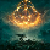

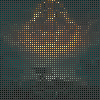

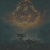

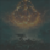

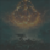

In [91]:
image_path = "img1.png"
original_image_array = load_image(image_path)

upscaled_image_array = upscale_image(original_image_array, 2)
downscaled_bilinear_array = downscale_bilinear(upscaled_image_array, original_image_array)
downscaled_bicubic_array = downscale_bicubic(upscaled_image_array, original_image_array)
downscaled_nearest_neighbour = downscale_nearest_neighbour(downscaled_bilinear_array, original_image_array)

original = Image.fromarray(original_image_array)
up = Image.fromarray(upscaled_image_array)
downscaled_bicubic = Image.fromarray(downscaled_bicubic_array)
downscaled_bilinear = Image.fromarray(downscaled_bilinear_array)
downscaled_nearest_neighbour = Image.fromarray(downscaled_nearest_neighbour)
display(original)
display(up)
display(downscaled_bicubic)
display(downscaled_bilinear)
display(downscaled_nearest_neighbour)

## GA Runs

#### bicubic_downscaled_mse() Cost Function

Baseline run

Generation 1: Best cost: 1543.2233333333334
Generation 2: Best cost: 1542.8124
Generation 3: Best cost: 1542.3398666666667
Generation 4: Best cost: 1541.6305333333332
Generation 5: Best cost: 1541.2894666666666
Generation 6: Best cost: 1540.9512
Generation 7: Best cost: 1540.5954666666667
Generation 8: Best cost: 1540.2886666666666
Generation 9: Best cost: 1539.8264
Generation 13: Best cost: 1538.8578666666667
Generation 16: Best cost: 1538.0476
Generation 17: Best cost: 1538.0102666666667
Generation 19: Best cost: 1537.6757333333333
Generation 20: Best cost: 1536.8196
Generation 25: Best cost: 1536.5636
Generation 27: Best cost: 1535.7061333333334
Generation 30: Best cost: 1535.0716
Generation 31: Best cost: 1535.0146666666667
Generation 34: Best cost: 1534.8341333333333
Generation 35: Best cost: 1534.0961333333332
Generation 36: Best cost: 1533.8210666666666
Generation 37: Best cost: 1533.6937333333333
Generation 38: Best cost: 1533.6329333333333
Generation 39: Best cost: 1532.849866

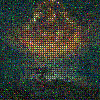

Original Image:


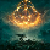

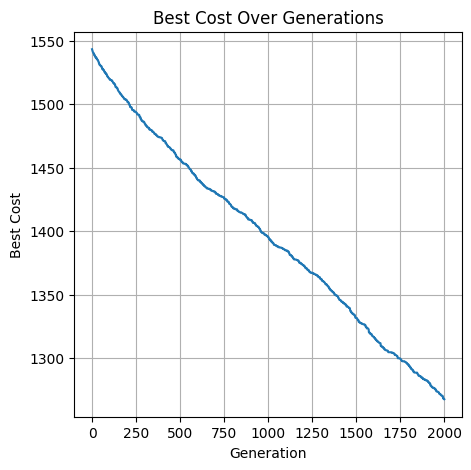

In [92]:
image_path = "img1.png"
original_image_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 100
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.01
params.range_of_gene_mutation = 15
params.explore_crossover = 0.1
params.max_number_of_generations = 2000
params.tournament_size = 7

prob = problem(original_image_array, bicubic_downscaled_mse)

# Run genetic algorithm
best = run_genetic(prob, params, False)

More Generations

Generation 1: Best cost: 1543.6236
Generation 2: Best cost: 1542.9042666666667
Generation 3: Best cost: 1542.3274666666666
Generation 4: Best cost: 1540.6966666666667
Generation 5: Best cost: 1540.2888
Generation 8: Best cost: 1539.6225333333334
Generation 10: Best cost: 1539.5246666666667
Generation 11: Best cost: 1539.3648
Generation 12: Best cost: 1539.1305333333332
Generation 13: Best cost: 1538.9306666666666
Generation 15: Best cost: 1538.1385333333333
Generation 19: Best cost: 1538.0885333333333
Generation 20: Best cost: 1537.5158666666666
Generation 21: Best cost: 1537.3725333333334
Generation 22: Best cost: 1536.8910666666666
Generation 23: Best cost: 1536.868
Generation 24: Best cost: 1536.8669333333332
Generation 25: Best cost: 1536.3698666666667
Generation 26: Best cost: 1536.094
Generation 27: Best cost: 1535.7990666666667
Generation 28: Best cost: 1535.5482666666667
Generation 29: Best cost: 1535.5412
Generation 30: Best cost: 1534.7876
Generation 32: Best cost: 1534.77
Ge

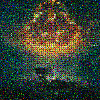

Original Image:


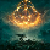

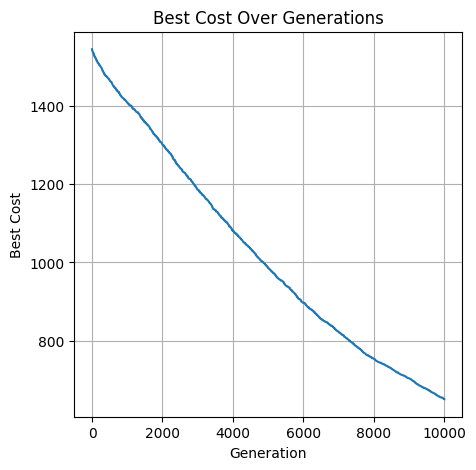

In [95]:
image_path = "img1.png"
original_image_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 100
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.01
params.range_of_gene_mutation = 15
params.explore_crossover = 0.1
params.max_number_of_generations = 10000
params.tournament_size = 7

prob = problem(original_image_array, bicubic_downscaled_mse)

# Run genetic algorithm
best = run_genetic(prob, params, False)

Increased exploration

Generation 1: Best cost: 1543.2673333333332
Generation 2: Best cost: 1542.8808
Generation 3: Best cost: 1541.9816
Generation 4: Best cost: 1540.9437333333333
Generation 5: Best cost: 1540.9318666666666
Generation 7: Best cost: 1540.4878666666666
Generation 8: Best cost: 1540.4653333333333
Generation 9: Best cost: 1539.6750666666667
Generation 10: Best cost: 1539.5814666666668
Generation 11: Best cost: 1539.3594666666668
Generation 16: Best cost: 1538.444
Generation 18: Best cost: 1536.904
Generation 24: Best cost: 1536.8702666666666
Generation 26: Best cost: 1535.9294666666667
Generation 35: Best cost: 1535.5653333333332
Generation 36: Best cost: 1535.226
Generation 38: Best cost: 1534.7976
Generation 40: Best cost: 1534.7217333333333
Generation 45: Best cost: 1534.4393333333333
Generation 46: Best cost: 1533.4957333333334
Generation 60: Best cost: 1532.9794666666667
Generation 62: Best cost: 1532.8714666666667
Generation 63: Best cost: 1532.5648
Generation 65: Best cost: 1531.93573333

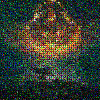

Original Image:


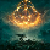

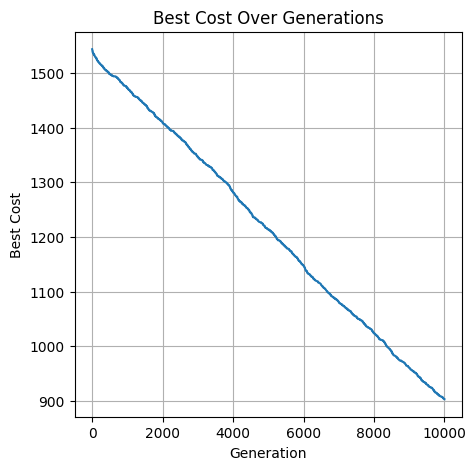

In [96]:
image_path = "img1.png"
original_image_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 100
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.02
params.range_of_gene_mutation = 15
params.explore_crossover = 0.2
params.max_number_of_generations = 10000
params.tournament_size = 5

prob = problem(original_image_array, bicubic_downscaled_mse)

# Run genetic algorithm
best = run_genetic(prob, params, False)

Increased Exploitation and Generations

Generation 1: Best cost: 1543.3316
Generation 2: Best cost: 1542.8410666666666
Generation 3: Best cost: 1542.1485333333333
Generation 4: Best cost: 1541.8234666666667
Generation 5: Best cost: 1541.2492
Generation 7: Best cost: 1540.5657333333334
Generation 8: Best cost: 1540.3130666666666
Generation 9: Best cost: 1540.0933333333332
Generation 10: Best cost: 1540.0598666666667
Generation 11: Best cost: 1540.0306666666668
Generation 12: Best cost: 1539.7421333333334
Generation 13: Best cost: 1539.4654666666668
Generation 14: Best cost: 1538.8608
Generation 15: Best cost: 1538.6594666666667
Generation 18: Best cost: 1538.0701333333334
Generation 19: Best cost: 1537.9441333333334
Generation 22: Best cost: 1537.9184
Generation 23: Best cost: 1536.7389333333333
Generation 24: Best cost: 1536.4412
Generation 26: Best cost: 1535.9896
Generation 27: Best cost: 1535.8186666666666
Generation 28: Best cost: 1535.2068
Generation 29: Best cost: 1534.692
Generation 32: Best cost: 1534.2162666666666
G

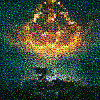

Original Image:


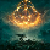

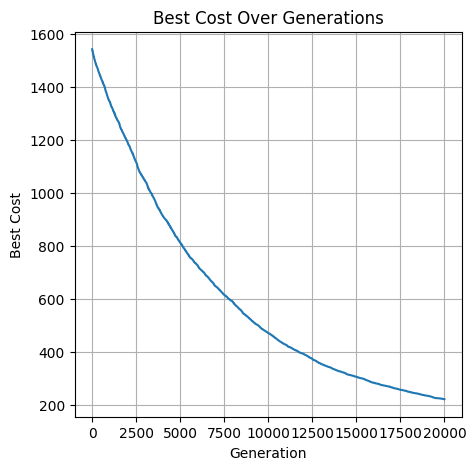

In [97]:
image_path = "img1.png"
original_image_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 100
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.01
params.range_of_gene_mutation = 15
params.explore_crossover = 0.05
params.max_number_of_generations = 25000
params.tournament_size = 10

prob = problem(original_image_array, bicubic_downscaled_mse)

# Run genetic algorithm
best = run_genetic(prob, params, False)

#### multi_downscaled_mse() Cost Function

Baseline run

Generation 1: Best cost: 1936.5264444444445
Generation 2: Best cost: 1935.9511555555555
Generation 3: Best cost: 1935.418
Generation 4: Best cost: 1934.4207999999999
Generation 5: Best cost: 1934.0016444444445
Generation 6: Best cost: 1933.2818222222222
Generation 7: Best cost: 1933.2268444444444
Generation 8: Best cost: 1933.1437333333333
Generation 9: Best cost: 1932.235422222222
Generation 11: Best cost: 1932.1851555555556
Generation 12: Best cost: 1932.0899111111112
Generation 13: Best cost: 1931.7841777777776
Generation 17: Best cost: 1930.844
Generation 18: Best cost: 1930.1950666666664
Generation 19: Best cost: 1928.4884444444444
Generation 22: Best cost: 1928.4208444444441
Generation 23: Best cost: 1928.0418666666665
Generation 24: Best cost: 1927.428222222222
Generation 25: Best cost: 1925.939111111111
Generation 28: Best cost: 1925.2644888888888
Generation 30: Best cost: 1925.1879111111111
Generation 31: Best cost: 1924.944666666667
Generation 32: Best cost: 1924.853733333333

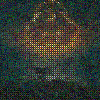

Original Image:


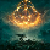

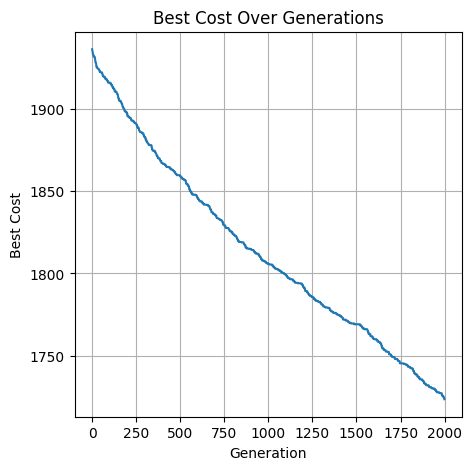

In [98]:
image_path = "img1.png"
original_image_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 100
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.01
params.range_of_gene_mutation = 15
params.explore_crossover = 0.1
params.max_number_of_generations = 2000
params.tournament_size = 7

prob = problem(original_image_array, multi_downscaled_mse)

# Run genetic algorithm
best= run_genetic(prob, params, False)

Increased Exploration

Generation 6: Best cost: 1936.7314666666668
Generation 36: Best cost: 1936.1282666666666
Generation 47: Best cost: 1935.7815555555555
Generation 61: Best cost: 1935.6059555555555
Generation 68: Best cost: 1933.6760888888891
Generation 90: Best cost: 1931.503422222222
Generation 93: Best cost: 1929.0240000000001
Generation 95: Best cost: 1928.9971555555555
Generation 101: Best cost: 1928.8892444444446
Generation 112: Best cost: 1928.4835555555555
Generation 114: Best cost: 1926.8992888888888
Generation 117: Best cost: 1925.2545333333335
Generation 160: Best cost: 1924.9224888888887
Generation 169: Best cost: 1923.1616888888886
Generation 184: Best cost: 1922.280133333333
Generation 210: Best cost: 1920.6081777777779
Generation 247: Best cost: 1919.7416444444443
Generation 356: Best cost: 1918.2796444444446
Generation 462: Best cost: 1917.7823555555558
Generation 680: Best cost: 1917.4135999999999
Generation 729: Best cost: 1916.7378666666666
Generation 829: Best cost: 1916.571288888889


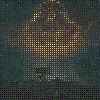

Original Image:


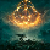

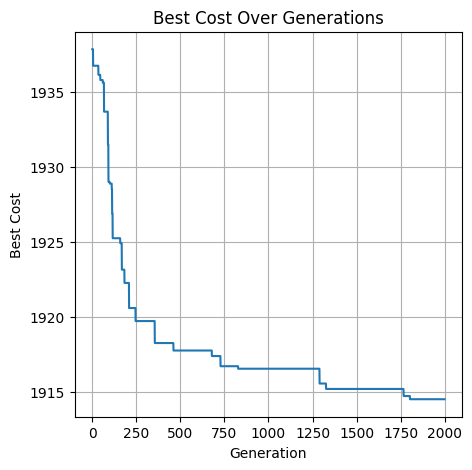

In [102]:
image_path = "img1.png"
original_image_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 150
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.05
params.range_of_gene_mutation = 25
params.explore_crossover = 0.2
params.max_number_of_generations = 2000
params.tournament_size = 5

prob = problem(original_image_array, multi_downscaled_mse)

# Run genetic algorithm
best = run_genetic(prob, params, False)

Increased Exploitation

Generation 1: Best cost: 1937.4194222222222
Generation 2: Best cost: 1936.903022222222
Generation 4: Best cost: 1936.3785333333333
Generation 5: Best cost: 1936.2721777777779
Generation 6: Best cost: 1936.138
Generation 7: Best cost: 1935.8903555555555
Generation 8: Best cost: 1935.5702666666668
Generation 9: Best cost: 1935.2157333333334
Generation 10: Best cost: 1935.116711111111
Generation 11: Best cost: 1934.8760000000002
Generation 12: Best cost: 1934.5323555555558
Generation 14: Best cost: 1934.398888888889
Generation 15: Best cost: 1934.2038222222225
Generation 17: Best cost: 1934.0878666666667
Generation 18: Best cost: 1933.9090222222221
Generation 19: Best cost: 1933.8147555555558
Generation 20: Best cost: 1933.543777777778
Generation 22: Best cost: 1933.1456444444445
Generation 23: Best cost: 1933.0624444444445
Generation 24: Best cost: 1932.9171555555556
Generation 25: Best cost: 1932.5130222222222
Generation 26: Best cost: 1932.4888
Generation 27: Best cost: 1932.4135111111

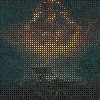

Original Image:


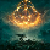

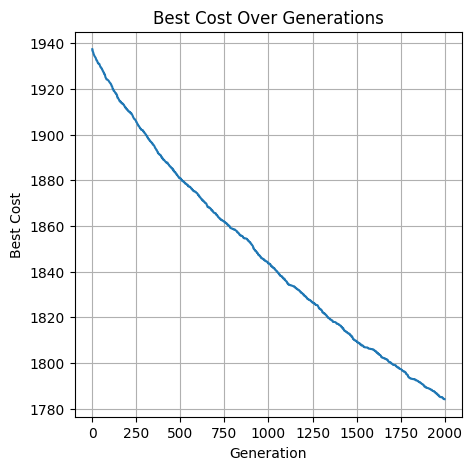

In [103]:
image_path = "img1.png"
original_image_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 100
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.005
params.range_of_gene_mutation = 5
params.explore_crossover = 0.1
params.max_number_of_generations = 2000
params.tournament_size = 10

prob = problem(original_image_array, multi_downscaled_mse)

# Run genetic algorithm
best= run_genetic(prob, params, False)

Balance of exploration vs exploitation

Generation 1: Best cost: 1936.3271555555555
Generation 2: Best cost: 1935.9037333333333
Generation 3: Best cost: 1935.4421777777777
Generation 4: Best cost: 1934.8381333333334
Generation 5: Best cost: 1934.1124444444442
Generation 6: Best cost: 1933.3456888888886
Generation 7: Best cost: 1933.2993777777776
Generation 8: Best cost: 1933.024311111111
Generation 9: Best cost: 1932.304488888889
Generation 10: Best cost: 1931.7156000000002
Generation 11: Best cost: 1931.1680888888889
Generation 13: Best cost: 1930.8887555555557
Generation 14: Best cost: 1929.989511111111
Generation 16: Best cost: 1929.1202222222225
Generation 17: Best cost: 1929.0599555555557
Generation 19: Best cost: 1929.0436444444447
Generation 20: Best cost: 1927.6187555555555
Generation 24: Best cost: 1927.455911111111
Generation 25: Best cost: 1926.8817333333334
Generation 26: Best cost: 1926.1067555555558
Generation 27: Best cost: 1925.7449777777776
Generation 28: Best cost: 1925.7038222222225
Generation 29: Best cos

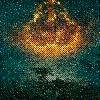

Original Image:


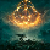

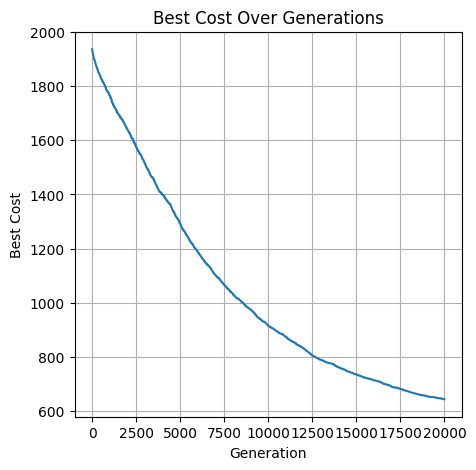

In [16]:
image_path = "img1.png"
original_image_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 100
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.01
params.range_of_gene_mutation = 15
params.explore_crossover = 0.1
params.max_number_of_generations = 20000
params.tournament_size = 10

prob = problem(original_image_array, multi_downscaled_mse)

# Run genetic algorithm
best= run_genetic(prob, params, False)

Increased exploitation with  more generations

Generation 1: Best cost: 1937.4013333333332
Generation 2: Best cost: 1937.2084000000002
Generation 3: Best cost: 1936.710488888889
Generation 4: Best cost: 1936.5862666666665
Generation 5: Best cost: 1936.4323555555557
Generation 6: Best cost: 1936.0518222222224
Generation 8: Best cost: 1935.9156444444445
Generation 9: Best cost: 1935.7189777777778
Generation 10: Best cost: 1935.6490222222221
Generation 11: Best cost: 1935.5413777777776
Generation 12: Best cost: 1935.457333333333
Generation 13: Best cost: 1935.2820444444444
Generation 14: Best cost: 1935.231288888889
Generation 15: Best cost: 1935.2160444444444
Generation 16: Best cost: 1934.9738222222222
Generation 17: Best cost: 1934.7411999999997
Generation 18: Best cost: 1934.5348000000001
Generation 20: Best cost: 1934.439377777778
Generation 21: Best cost: 1934.2946222222224
Generation 23: Best cost: 1934.145911111111
Generation 24: Best cost: 1934.0202666666667
Generation 25: Best cost: 1933.9059555555557
Generation 27: Best cos

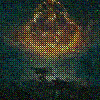

Original Image:


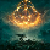

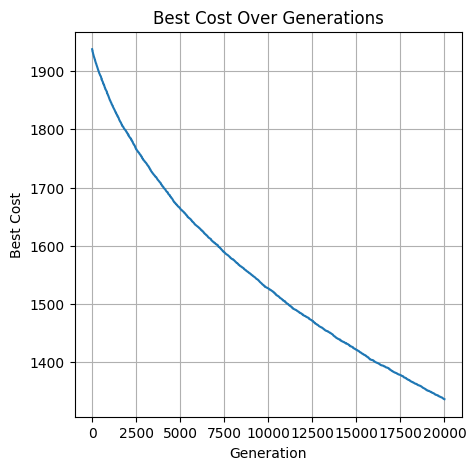

In [17]:
image_path = "img1.png"
original_image_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 100
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.005
params.range_of_gene_mutation = 5
params.explore_crossover = 0.1
params.max_number_of_generations = 20000
params.tournament_size = 10

prob = problem(original_image_array, multi_downscaled_mse)

# Run genetic algorithm
best= run_genetic(prob, params, False)

Large mutation range with low mutation rate

Generation 1: Best cost: 1936.9176888888887
Generation 2: Best cost: 1934.833422222222
Generation 3: Best cost: 1934.7013333333334
Generation 4: Best cost: 1934.1981333333333
Generation 5: Best cost: 1931.7141777777779
Generation 6: Best cost: 1930.597288888889
Generation 7: Best cost: 1929.5493333333334
Generation 8: Best cost: 1928.5956444444444
Generation 11: Best cost: 1927.5720888888889
Generation 12: Best cost: 1927.567866666667
Generation 15: Best cost: 1927.4527555555558
Generation 17: Best cost: 1926.5684444444444
Generation 19: Best cost: 1924.7698666666668
Generation 20: Best cost: 1924.6855555555555
Generation 22: Best cost: 1923.5518666666667
Generation 23: Best cost: 1923.1286666666667
Generation 24: Best cost: 1920.2739555555554
Generation 29: Best cost: 1918.9745777777778
Generation 31: Best cost: 1918.9315555555556
Generation 32: Best cost: 1917.196222222222
Generation 37: Best cost: 1915.5740444444446
Generation 39: Best cost: 1915.549866666667
Generation 41: Best cos

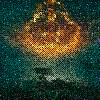

Original Image:


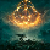

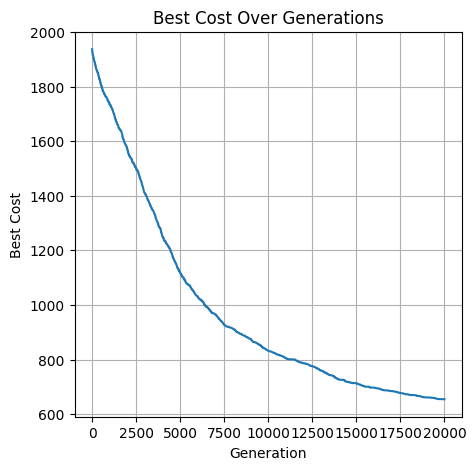

In [106]:
image_path = "img1.png"
original_image_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 100
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.01
params.range_of_gene_mutation = 25
params.explore_crossover = 0.1
params.max_number_of_generations = 20000
params.tournament_size = 10

prob = problem(original_image_array, multi_downscaled_mse)

# Run genetic algorithm
best= run_genetic(prob, params, False)

Smaller mutation range with higher mutation rate

Generation 1: Best cost: 1937.0830666666668
Generation 2: Best cost: 1936.1476
Generation 3: Best cost: 1934.6904444444444
Generation 4: Best cost: 1933.434
Generation 5: Best cost: 1932.4920444444444
Generation 6: Best cost: 1930.7914222222223
Generation 8: Best cost: 1930.2039555555555
Generation 9: Best cost: 1929.511822222222
Generation 10: Best cost: 1928.9726666666666
Generation 11: Best cost: 1928.4352888888889
Generation 12: Best cost: 1927.6386666666665
Generation 14: Best cost: 1926.1637333333335
Generation 15: Best cost: 1926.1610222222218
Generation 18: Best cost: 1925.6307555555557
Generation 20: Best cost: 1924.9212888888887
Generation 21: Best cost: 1924.4740000000002
Generation 22: Best cost: 1924.2115555555556
Generation 23: Best cost: 1923.0901333333331
Generation 25: Best cost: 1922.9619555555555
Generation 27: Best cost: 1922.816488888889
Generation 29: Best cost: 1921.6950666666664
Generation 31: Best cost: 1921.299511111111
Generation 33: Best cost: 1919.656399999

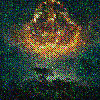

Original Image:


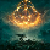

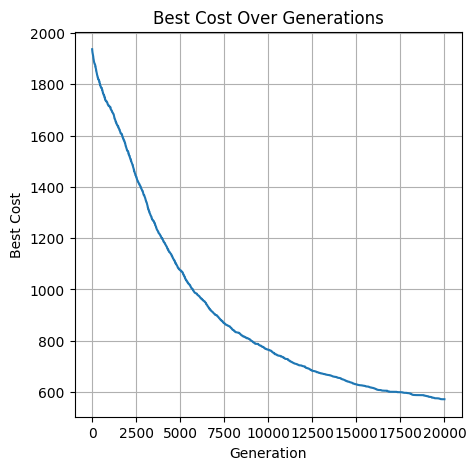

In [108]:
image_path = "img1.png"
original_image_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 100
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.0075
params.range_of_gene_mutation = 25
params.explore_crossover = 0.1
params.max_number_of_generations = 20000
params.tournament_size = 10

prob = problem(original_image_array, multi_downscaled_mse)

# Run genetic algorithm
best= run_genetic(prob, params, False)

Heavy exploitation over many generations

Generation 1: Best cost: 1937.0126222222223
Generation 2: Best cost: 1936.5051555555556
Generation 3: Best cost: 1936.1182666666664
Generation 4: Best cost: 1936.0767555555558
Generation 5: Best cost: 1935.6277777777777
Generation 6: Best cost: 1934.7604
Generation 7: Best cost: 1934.6330222222223
Generation 8: Best cost: 1934.3230666666668
Generation 9: Best cost: 1933.671111111111
Generation 10: Best cost: 1933.3879555555552
Generation 11: Best cost: 1932.948577777778
Generation 12: Best cost: 1932.7195111111112
Generation 13: Best cost: 1932.3871555555554
Generation 14: Best cost: 1931.8285333333333
Generation 15: Best cost: 1931.5334666666665
Generation 16: Best cost: 1931.0336
Generation 17: Best cost: 1930.6473777777776
Generation 18: Best cost: 1930.4944000000003
Generation 19: Best cost: 1929.754488888889
Generation 20: Best cost: 1928.9448
Generation 22: Best cost: 1928.446
Generation 23: Best cost: 1928.1661333333334
Generation 24: Best cost: 1927.485688888889
Generation 25: 

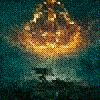

Original Image:


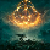

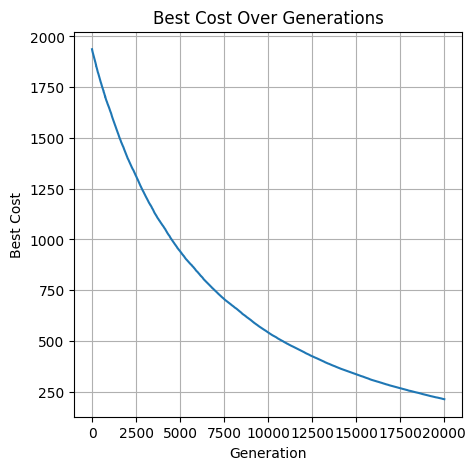

In [110]:
image_path = "img1.png"
original_image_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 100
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.001
params.range_of_gene_mutation = 15
params.explore_crossover = 0.01
params.max_number_of_generations = 20000
params.tournament_size = 15

prob = problem(original_image_array, multi_downscaled_mse)

# Run genetic algorithm
best= run_genetic(prob, params, False)

Best result:

Generation 1: Best cost: 1937.3773333333331
Generation 2: Best cost: 1937.010266666667
Generation 3: Best cost: 1936.6169333333335
Generation 4: Best cost: 1936.0096888888886
Generation 5: Best cost: 1935.8485777777778
Generation 6: Best cost: 1935.5477333333336
Generation 7: Best cost: 1935.0349333333334
Generation 8: Best cost: 1934.8012444444441
Generation 9: Best cost: 1934.2855111111112
Generation 10: Best cost: 1933.812311111111
Generation 11: Best cost: 1933.4908000000003
Generation 12: Best cost: 1933.2786666666668
Generation 13: Best cost: 1932.7049777777777
Generation 14: Best cost: 1932.2260444444444
Generation 15: Best cost: 1931.908311111111
Generation 16: Best cost: 1931.6418222222226
Generation 17: Best cost: 1931.2449333333334
Generation 18: Best cost: 1930.4156
Generation 19: Best cost: 1929.9129777777778
Generation 20: Best cost: 1929.4992444444445
Generation 21: Best cost: 1929.178222222222
Generation 22: Best cost: 1928.729022222222
Generation 23: Best cost: 1928.33

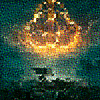

Original Image:


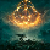

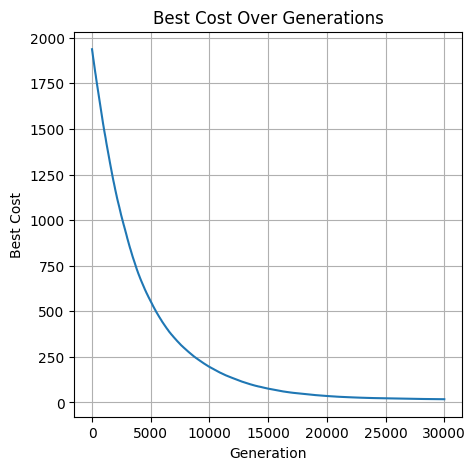

In [114]:
image_path = "img1.png"
original_image_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 100
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.001
params.range_of_gene_mutation = 15
params.explore_crossover = 0.01
params.max_number_of_generations = 30000
params.tournament_size = 50

prob = problem(original_image_array, multi_downscaled_mse)

# Run genetic algorithm
best= run_genetic(prob, params, False)

## Results and Conclusions (~10%)

### Results

Multiple runs of the algorithm were performed with varying parameters aiming to balance exploration vs exploitation, while comparing the two cost functions.

**bicubic_downscaled_mse:**
- This cost function generally led to faster convergence - the cost dropped quicker in early generations.
- The GA moved towards images that satisfied the bicubic downscaling cost function but contained noticeable noise and unnatural-looking pixels at the upscaled resolution.
- Even when run for many generations, as the MSE cost got lower, the visual quality didn't improve due to the noisy pixels.

**multi_downscaled_mse:**
- Convergence with this cost function was slower, needing more generations to achieve lower cost.
- The results were visually better than the single bicubic method. The stricter constraint of the average MSE across bicubic, bilinear, and nearest-neighbor downscaling reduced the noisy images that could "fool" the single bicubic method.
- The best results were achieved with parameters favouring heavy exploitation over many generations:
    - A very low mutation rate (0.001)
    - A moderate mutation range (15)
    - Very low crossover exploration (0.01)
    - A large tournament size (50)
    - A very high number of generations (30000)
- For the best visual results, once the algorithm found a promising region of the search space, smaller steps over a large number of generations are needed.

Bicubic MSE vs Multi Downscaled MSE - Same MSE with noticeably different results:



### Conclusions

**Compute Time:** Upscaling an image via GA is computationally intensive and requires many generations, up to tens of thousands to achieve a visually pleasing result. Due to the vast search space, steady but slow improvement over long runs is no surprise.

**Exploration vs Exploitation:** Finding the balance between exploration (higher mutation rate/range, higher crossover exploration, smaller tournament size) and exploitation (the opposite) plays a big role. These parameters directly affected speed and the quality of the final result. Too much exploration prevented the GA from narrowing in on a promising area of the search space, while starting with too much exploitation allowed the GA to get stuck in suboptimal solutions.

**Feasibility:** Genetic Algorithms, when guided by a downscaling consistency cost function, *can* be successfully applied to the problem of image upscaling, and can produce a visually improved upscaled image.

Overall, this assignment demonstrated the capability of GAs for this problem, however the high computational cost and the challenge of creating a suitable cost function makes this an impractical replacement for existing upscaling techniques like bicubic interpolation. However, this serves as a valuable learning experience in applying a GA to this interesting problem.

### Future directions and improvements

- Dynamic adjustments to parameters. Starting with higher exploration and shifting to higher exploitation may improve running time and require fewer generations
- Instead of starting from an upscaled image filled with median pixel values, start with a bicubic interpolation upscale. The GA could then focus on refining the image for sharpening and potentially smooth aliasing.

Original Image:


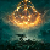


Image 2x Upscale with GA:


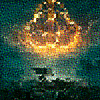


Image 2x Upscale with traditional Bicubic Interpolation:


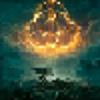

In [23]:
image = load_image("img1.png")
pillow_image = Image.fromarray(image)
upscaled = pillow_image.resize((image.shape[1]*2, image.shape[0]*2), Image.BICUBIC)
print("Original Image:")
display(Image.open("img1.png"))
print("\nImage 2x Upscale with GA:")
display(Image.open("best.png"))
print("\nImage 2x Upscale with traditional Bicubic Interpolation:")
display(upscaled)